In [35]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)



In [36]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import library
import sindy

import neuromancer.psl as psl
from neuromancer.system import Node, System
from neuromancer.modules import blocks
from neuromancer.modules.activations import activations
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.dynamics import ode, integrators
from neuromancer.plot import pltCL, pltPhase
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [37]:
# ground truth system model
gt_model = psl.nonautonomous.TwoTank(seed=9)
# sampling rate
ts = gt_model.params[1]['ts']
# problem dimensions
nx = gt_model.nx    # number of states
nu = gt_model.nu    # number of control inputs
nref = nx           # number of references
# constraints bounds
umin = 0.
umax = 1.
xmin = 0.
xmax = 1.
sys = gt_model


# white-box ODE model with no-plant model mismatch
two_tank = ode.TwoTankParam()                   # ODE system equations implemented in PyTorch
two_tank.c1 = nn.Parameter(torch.tensor(gt_model.c1), requires_grad=False)
two_tank.c2 = nn.Parameter(torch.tensor(gt_model.c2), requires_grad=False)
# integrate continuous time ODE
integrator = integrators.RK4(two_tank, h=torch.tensor(ts))   # using 4th order runge kutta integrator
# symbolic system model
integrator_node = Node(integrator, ['xn', 'u'], ['xn'], name='model')


In [38]:
def get_policy_data(nsteps, n_samples):
    #  sampled references for training the policy
    list_refs = [torch.rand(1, 1)*torch.ones(nsteps+1, nref) for k in range(n_samples)]
    ref = torch.cat(list_refs)
    batched_ref = ref.reshape([n_samples, nsteps+1, nref])
    # Training dataset
    train_data = DictDataset({'xn': torch.rand(n_samples, 1, nx),   # sampled initial conditions of states
                              'r': batched_ref}, name='train')

    # sampled references for development set
    list_refs = [torch.rand(1, 1)*torch.ones(nsteps+1, nref) for k in range(n_samples)]
    ref = torch.cat(list_refs)
    batched_ref = ref.reshape([n_samples, nsteps+1, nref])
    # Development dataset
    dev_data = DictDataset({'xn': torch.rand(n_samples, 1, nx),    # sampled initial conditions of states
                            'r': batched_ref}, name='dev')

    # torch dataloaders
    batch_size = 200
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                               collate_fn=train_data.collate_fn,
                                               shuffle=False)
    dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=batch_size,
                                             collate_fn=dev_data.collate_fn,
                                             shuffle=False)
    return train_loader, dev_loader

nsteps = 50  # prediction horizon
n_samples = 3000    # number of sampled scenarios

train_loader, dev_loader = get_policy_data(nsteps, n_samples)

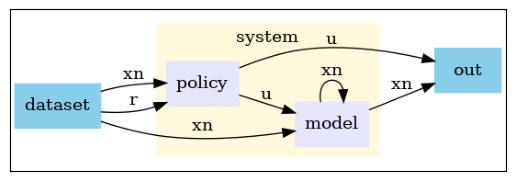

In [39]:
# neural net control policy with hard control action bounds
net = blocks.MLP_bounds(insize=nx + nref, outsize=nu, hsizes=[32, 32],
                    nonlin=activations['gelu'], min=umin, max=umax)
policy = Node(net, ['xn', 'r'], ['u'], name='policy')

# closed-loop system model
cl_system = System([policy, integrator_node], nsteps=nsteps)
cl_system.show()


In [40]:
# variables
x = variable('xn')
ref = variable('r')
# objectives
regulation_loss = 5. * ((x == ref) ^ 2)  # target posistion
# constraints
state_lower_bound_penalty = 10.*(x > xmin)
state_upper_bound_penalty = 10.*(x < xmax)
terminal_lower_bound_penalty = 10.*(x[:, [-1], :] > ref-0.01)
terminal_upper_bound_penalty = 10.*(x[:, [-1], :] < ref+0.01)
# objectives and constraints names for nicer plot
regulation_loss.name = 'state_loss'
state_lower_bound_penalty.name = 'x_min'
state_upper_bound_penalty.name = 'x_max'
terminal_lower_bound_penalty.name = 'y_N_min'
terminal_upper_bound_penalty.name = 'y_N_max'
# list of constraints and objectives
objectives = [regulation_loss]
constraints = [
    state_lower_bound_penalty,
    state_upper_bound_penalty,
    terminal_lower_bound_penalty,
    terminal_upper_bound_penalty,
]


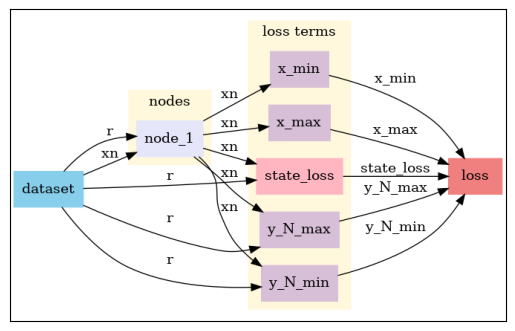

In [41]:

# data (x_k, r_k) -> parameters (xi_k) -> policy (u_k) -> dynamics (x_k+1)
components = [cl_system]
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)
# plot computational graph
problem.show()

In [42]:
optimizer = torch.optim.AdamW(policy.parameters(), lr=0.002)
#  Neuromancer trainer
trainer = Trainer(
    problem,
    train_loader, dev_loader,
    optimizer=optimizer,
    epochs=200,
    train_metric='train_loss',
    eval_metric='dev_loss',
    warmup=50,
    patience=20
)
# Train control policy
best_model = trainer.train()
# load best trained model
trainer.model.load_state_dict(best_model)



epoch: 0  train_loss: 4.736508369445801
epoch: 1  train_loss: 3.8805418014526367
epoch: 2  train_loss: 3.2483129501342773
epoch: 3  train_loss: 2.3616526126861572
epoch: 4  train_loss: 1.329271912574768
epoch: 5  train_loss: 1.0159586668014526
epoch: 6  train_loss: 0.8617544174194336
epoch: 7  train_loss: 0.7372915148735046
epoch: 8  train_loss: 0.6343743205070496
epoch: 9  train_loss: 0.5478888154029846
epoch: 10  train_loss: 0.483180433511734
epoch: 11  train_loss: 0.43613138794898987
epoch: 12  train_loss: 0.4017368257045746
epoch: 13  train_loss: 0.3754909634590149
epoch: 14  train_loss: 0.35497552156448364
epoch: 15  train_loss: 0.33764904737472534
epoch: 16  train_loss: 0.32289430499076843
epoch: 17  train_loss: 0.310822457075119
epoch: 18  train_loss: 0.3005515933036804
epoch: 19  train_loss: 0.2922230362892151
epoch: 20  train_loss: 0.2846885323524475
epoch: 21  train_loss: 0.27795520424842834
epoch: 22  train_loss: 0.27241188287734985
epoch: 23  train_loss: 0.26764121651649475

<All keys matched successfully>

In [43]:
nsteps = 750
step_length = 150
torch.manual_seed(0)
seed = 20
rng = np.random.default_rng(seed)
# generate reference
np_refs = psl.signals.step(nsteps+1, 1, min=xmin, max=xmax, randsteps=5, rng=rng)
R = torch.tensor(np_refs, dtype=torch.float32).reshape(1, nsteps+1, 1)
torch_ref = torch.cat([R, R], dim=-1)
# generate initial data for closed loop simulation
data = {'xn': torch.rand(1, 1, nx, dtype=torch.float32),
        'r': torch_ref}

### Rollout over the ground truth system (used for training)

(<Figure size 2000x1600 with 2 Axes>,
 array([[<Axes: xlabel='Time', ylabel='y'>],
        [<Axes: xlabel='Time', ylabel='u'>]], dtype=object))

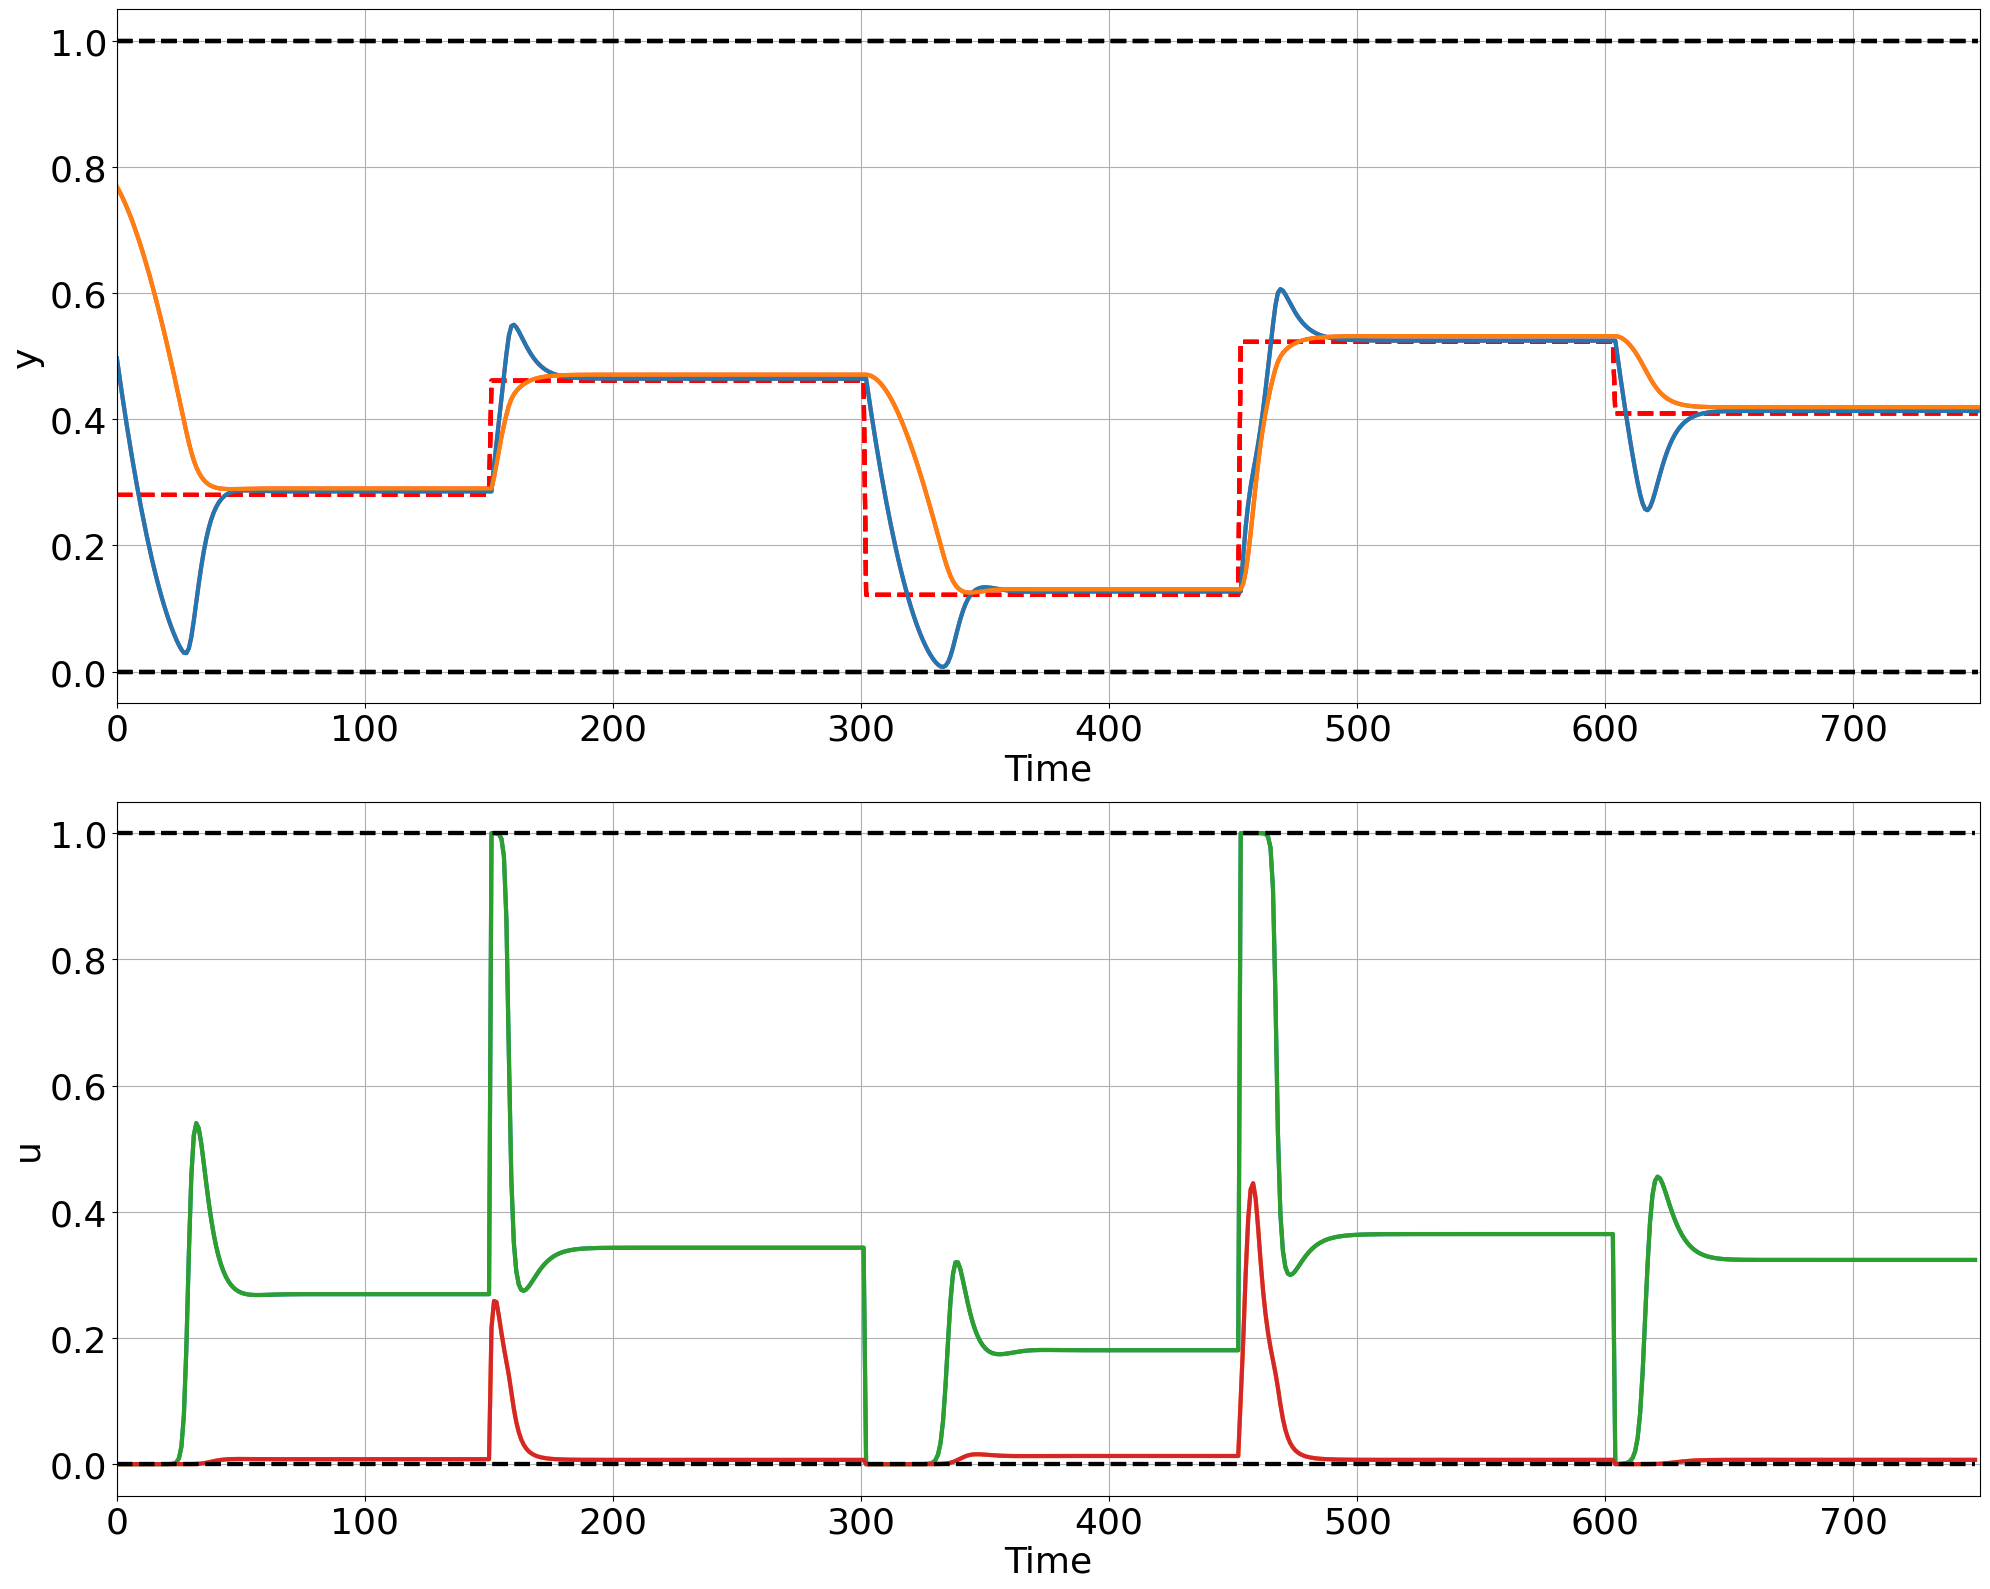

In [44]:
two_tank.c1 = nn.Parameter(torch.tensor(gt_model.c1, requires_grad=False))
two_tank.c2 = nn.Parameter(torch.tensor(gt_model.c2, requires_grad=False))

cl_system.nsteps = nsteps
# perform closed-loop simulation
trajectories = cl_system(data)

# constraints bounds
Umin = umin * np.ones([nsteps, nu])
Umax = umax * np.ones([nsteps, nu])
Xmin = xmin * np.ones([nsteps+1, nx])
Xmax = xmax * np.ones([nsteps+1, nx])
# plot closed loop trajectories
pltCL(Y=trajectories['xn'].detach().reshape(nsteps + 1, nx),
      R=trajectories['r'].detach().reshape(nsteps + 1, nref),
      U=trajectories['u'].detach().reshape(nsteps, nu),
      Umin=Umin, Umax=Umax, Ymin=Xmin, Ymax=Xmax)

### Changing the ODE parameters (Adding Noise)

In [45]:
# noise_level = 0.4
# noise = torch.randn(1) * noise_level
# two_tank.c1 = nn.Parameter(torch.tensor(gt_model.c1) + noise, requires_grad=False)
# two_tank.c2 = nn.Parameter(torch.tensor(gt_model.c2) + noise, requires_grad=False)

two_tank.c1 = nn.Parameter(torch.tensor(0.15), requires_grad=False)
two_tank.c2 = nn.Parameter(torch.tensor(0.03), requires_grad=False)
print("New c1: ",two_tank.c1)
print("New c2: ",two_tank.c2)

New c1:  Parameter containing:
tensor(0.1500)
New c2:  Parameter containing:
tensor(0.0300)


### Rolling over new system

(<Figure size 2000x1600 with 2 Axes>,
 array([[<Axes: xlabel='Time', ylabel='y'>],
        [<Axes: xlabel='Time', ylabel='u'>]], dtype=object))

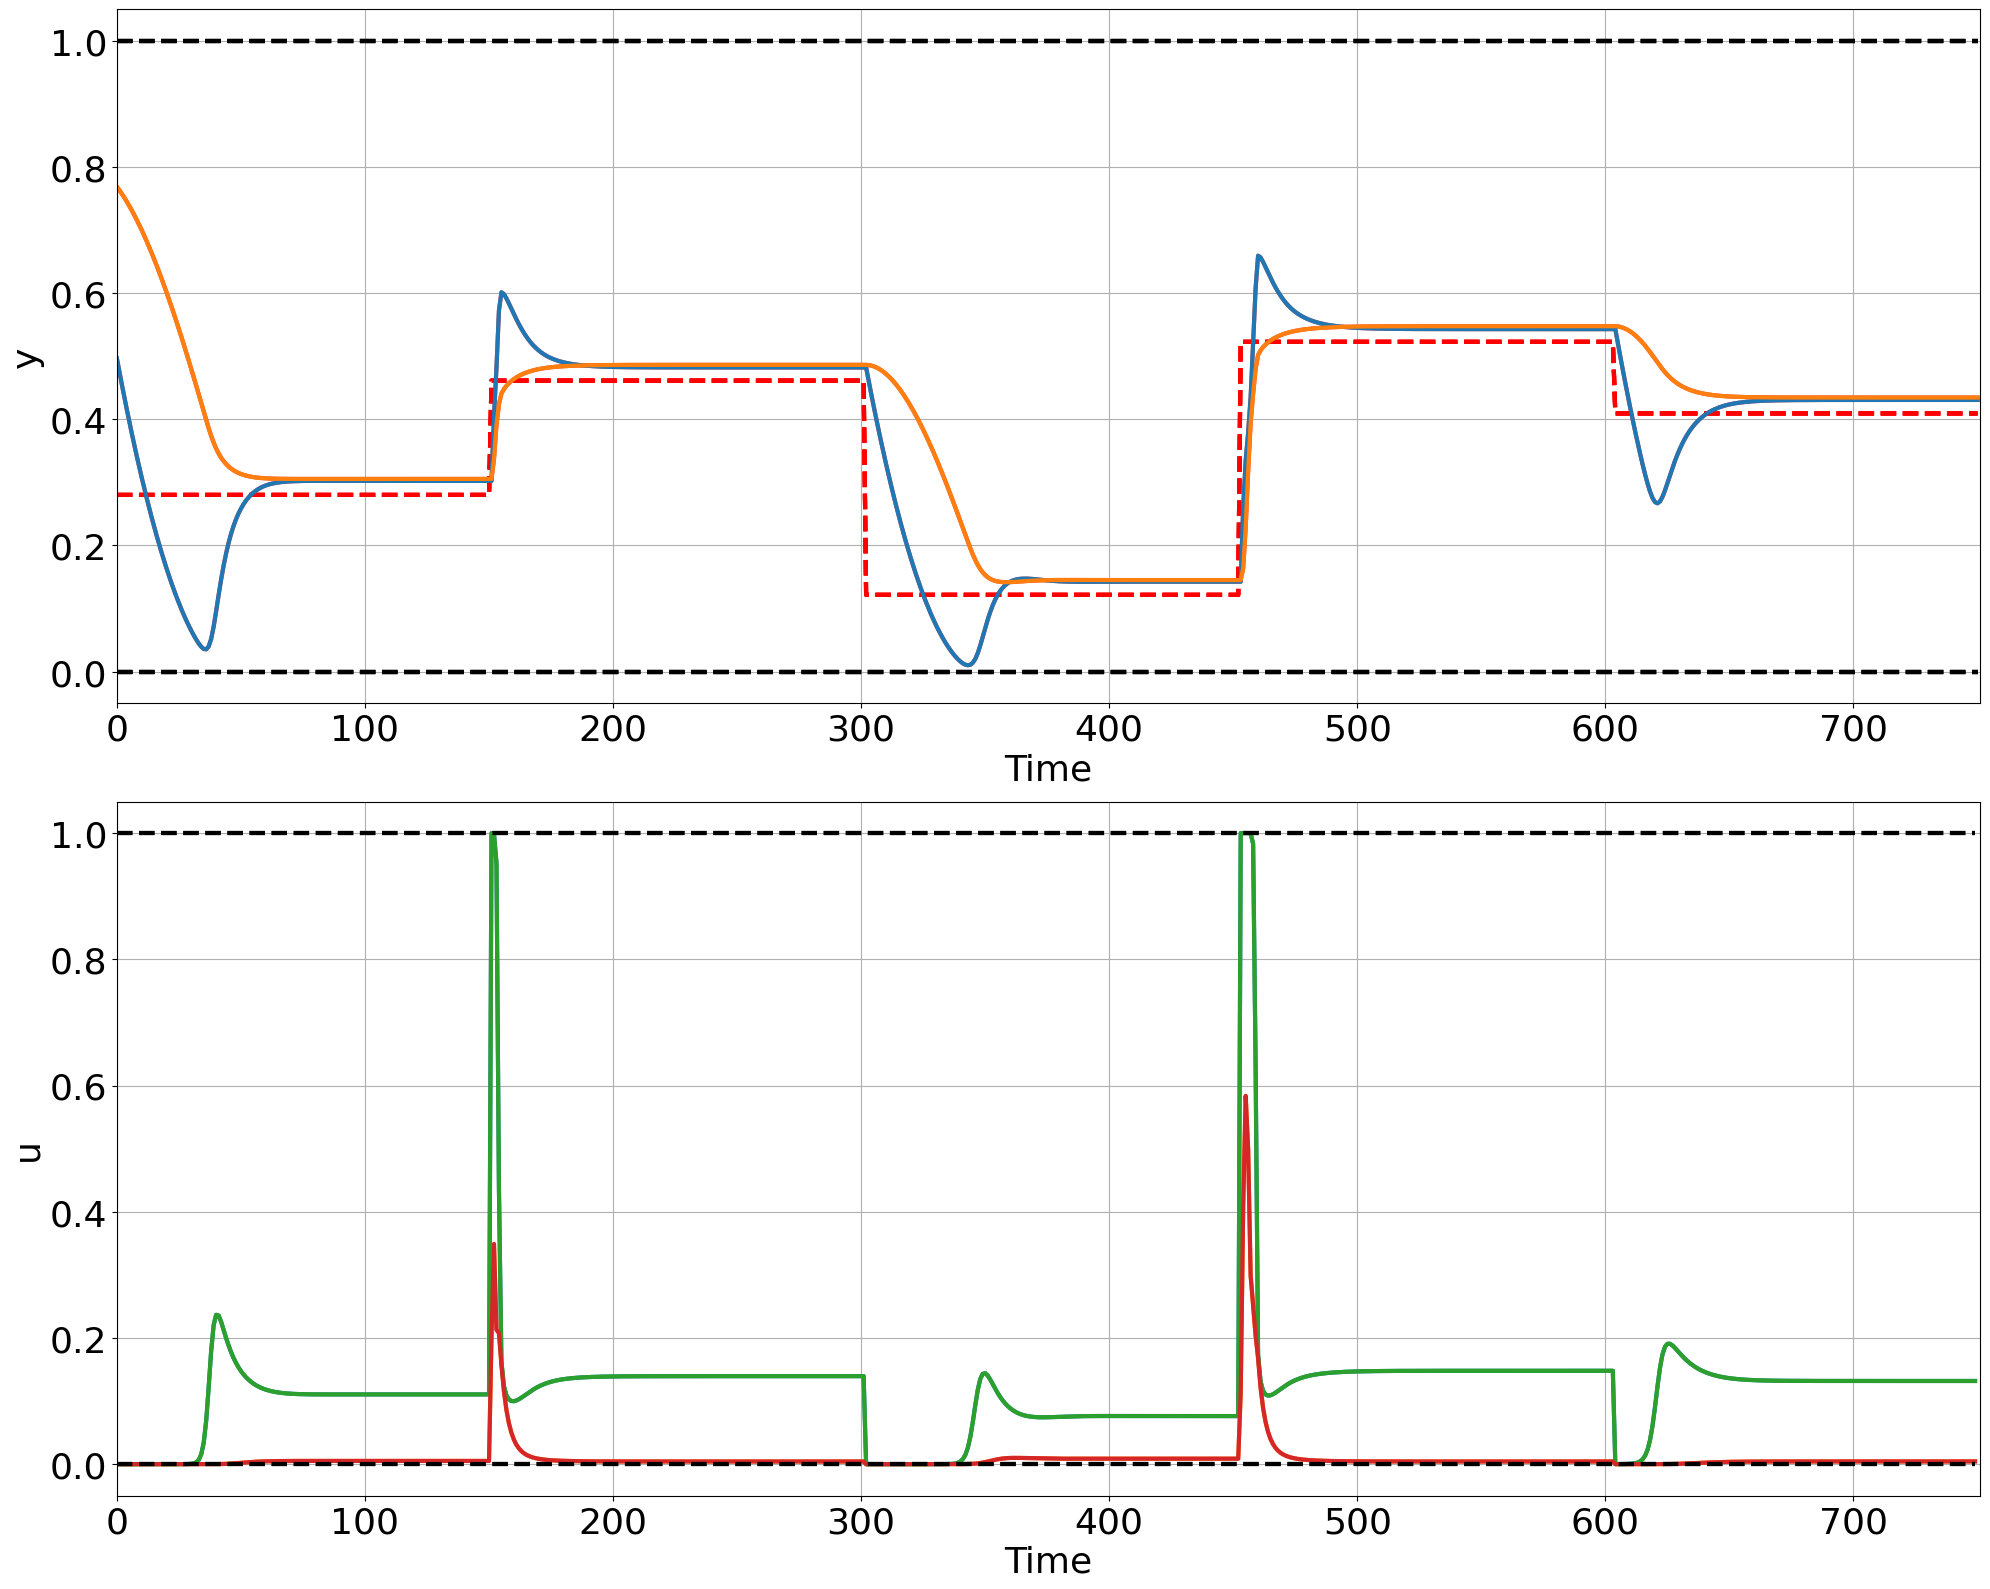

In [46]:
cl_system.nsteps = nsteps
# perform closed-loop simulation
trajectories = cl_system(data)

# constraints bounds
Umin = umin * np.ones([nsteps, nu])
Umax = umax * np.ones([nsteps, nu])
Xmin = xmin * np.ones([nsteps+1, nx])
Xmax = xmax * np.ones([nsteps+1, nx])
# plot closed loop trajectories
pltCL(Y=trajectories['xn'].detach().reshape(nsteps + 1, nx),
      R=trajectories['r'].detach().reshape(nsteps + 1, nref),
      U=trajectories['u'].detach().reshape(nsteps, nu),
      Umin=Umin, Umax=Umax, Ymin=Xmin, Ymax=Xmax)

### Online Adaptation

we start rolling out with the initial value, and then after taking each step, we train the model with the data we have.
For example, we start at t=0, we go to the next step, we train the model with the loss w.r.t the policy parameters. (we gradually increase the horizon upto horizon=50). This continues untill the end the of the test data


In [47]:
#setting intial value and the horizon
horizon = 10
x_trajectory = data['xn'].detach()[:, 0, :].unsqueeze(1)  # Shape: (batch, 1, 2)

In [48]:
#defining criterion and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(policy.parameters(), lr=0.001)


In [49]:
#Online adaptation loop:
for i in range (1,len(data['r'][0])):
    print('------', "Steping time step: ",i, '-------')
    #We rollout the closed loop system with the initial value:
    cl_system.nsteps = i
    trajectories = cl_system(data)

    #gradually increasing the horizon:
    l_horizon = min(i,horizon)

    #Getting the last l_horizon data from test data and calculate the loss
    T_xn = len(trajectories['xn'][0])
    loss = 5. * criterion(trajectories['xn'][:,-l_horizon:, :], trajectories['r'][:, T_xn - l_horizon : T_xn, :]) + criterion(trajectories['xn'], trajectories['r'][:, :T_xn])

    #backprop through policy network
    optimizer.zero_grad()
    loss.backward()

    #taking gradient update steps
    for _ in range(5):
        optimizer.step()
    print('-------', f"Loss in {i}th steps: ",loss.item(), '-------')

    #setting the initial value to the latest timestep (this is for knowing how the controller is performing online):
    cl_system.nsteps = 1
    next_step_data = cl_system({'xn': x_trajectory[:,-1,:].unsqueeze(0), 'r': data['r'][:, len(x_trajectory[0]), :].unsqueeze(0)})
    x_trajectory = torch.cat([x_trajectory, next_step_data['xn'].detach()[:,-1:,:]], dim=1)


------ Steping time step:  1 -------
------- Loss in 1th steps:  0.8171432018280029 -------
------ Steping time step:  2 -------
------- Loss in 2th steps:  0.7975223660469055 -------
------ Steping time step:  3 -------
------- Loss in 3th steps:  0.7786154747009277 -------
------ Steping time step:  4 -------
------- Loss in 4th steps:  0.7603957653045654 -------
------ Steping time step:  5 -------
------- Loss in 5th steps:  0.7428379058837891 -------
------ Steping time step:  6 -------
------- Loss in 6th steps:  0.7259167432785034 -------
------ Steping time step:  7 -------
------- Loss in 7th steps:  0.7096086740493774 -------
------ Steping time step:  8 -------
------- Loss in 8th steps:  0.6938908100128174 -------
------ Steping time step:  9 -------
------- Loss in 9th steps:  0.678740918636322 -------
------ Steping time step:  10 -------
------- Loss in 10th steps:  0.6641378402709961 -------
------ Steping time step:  11 -------
------- Loss in 11th steps:  0.6361842155

(<Figure size 2000x1600 with 2 Axes>,
 array([[<Axes: xlabel='Time', ylabel='y'>],
        [<Axes: xlabel='Time', ylabel='u'>]], dtype=object))

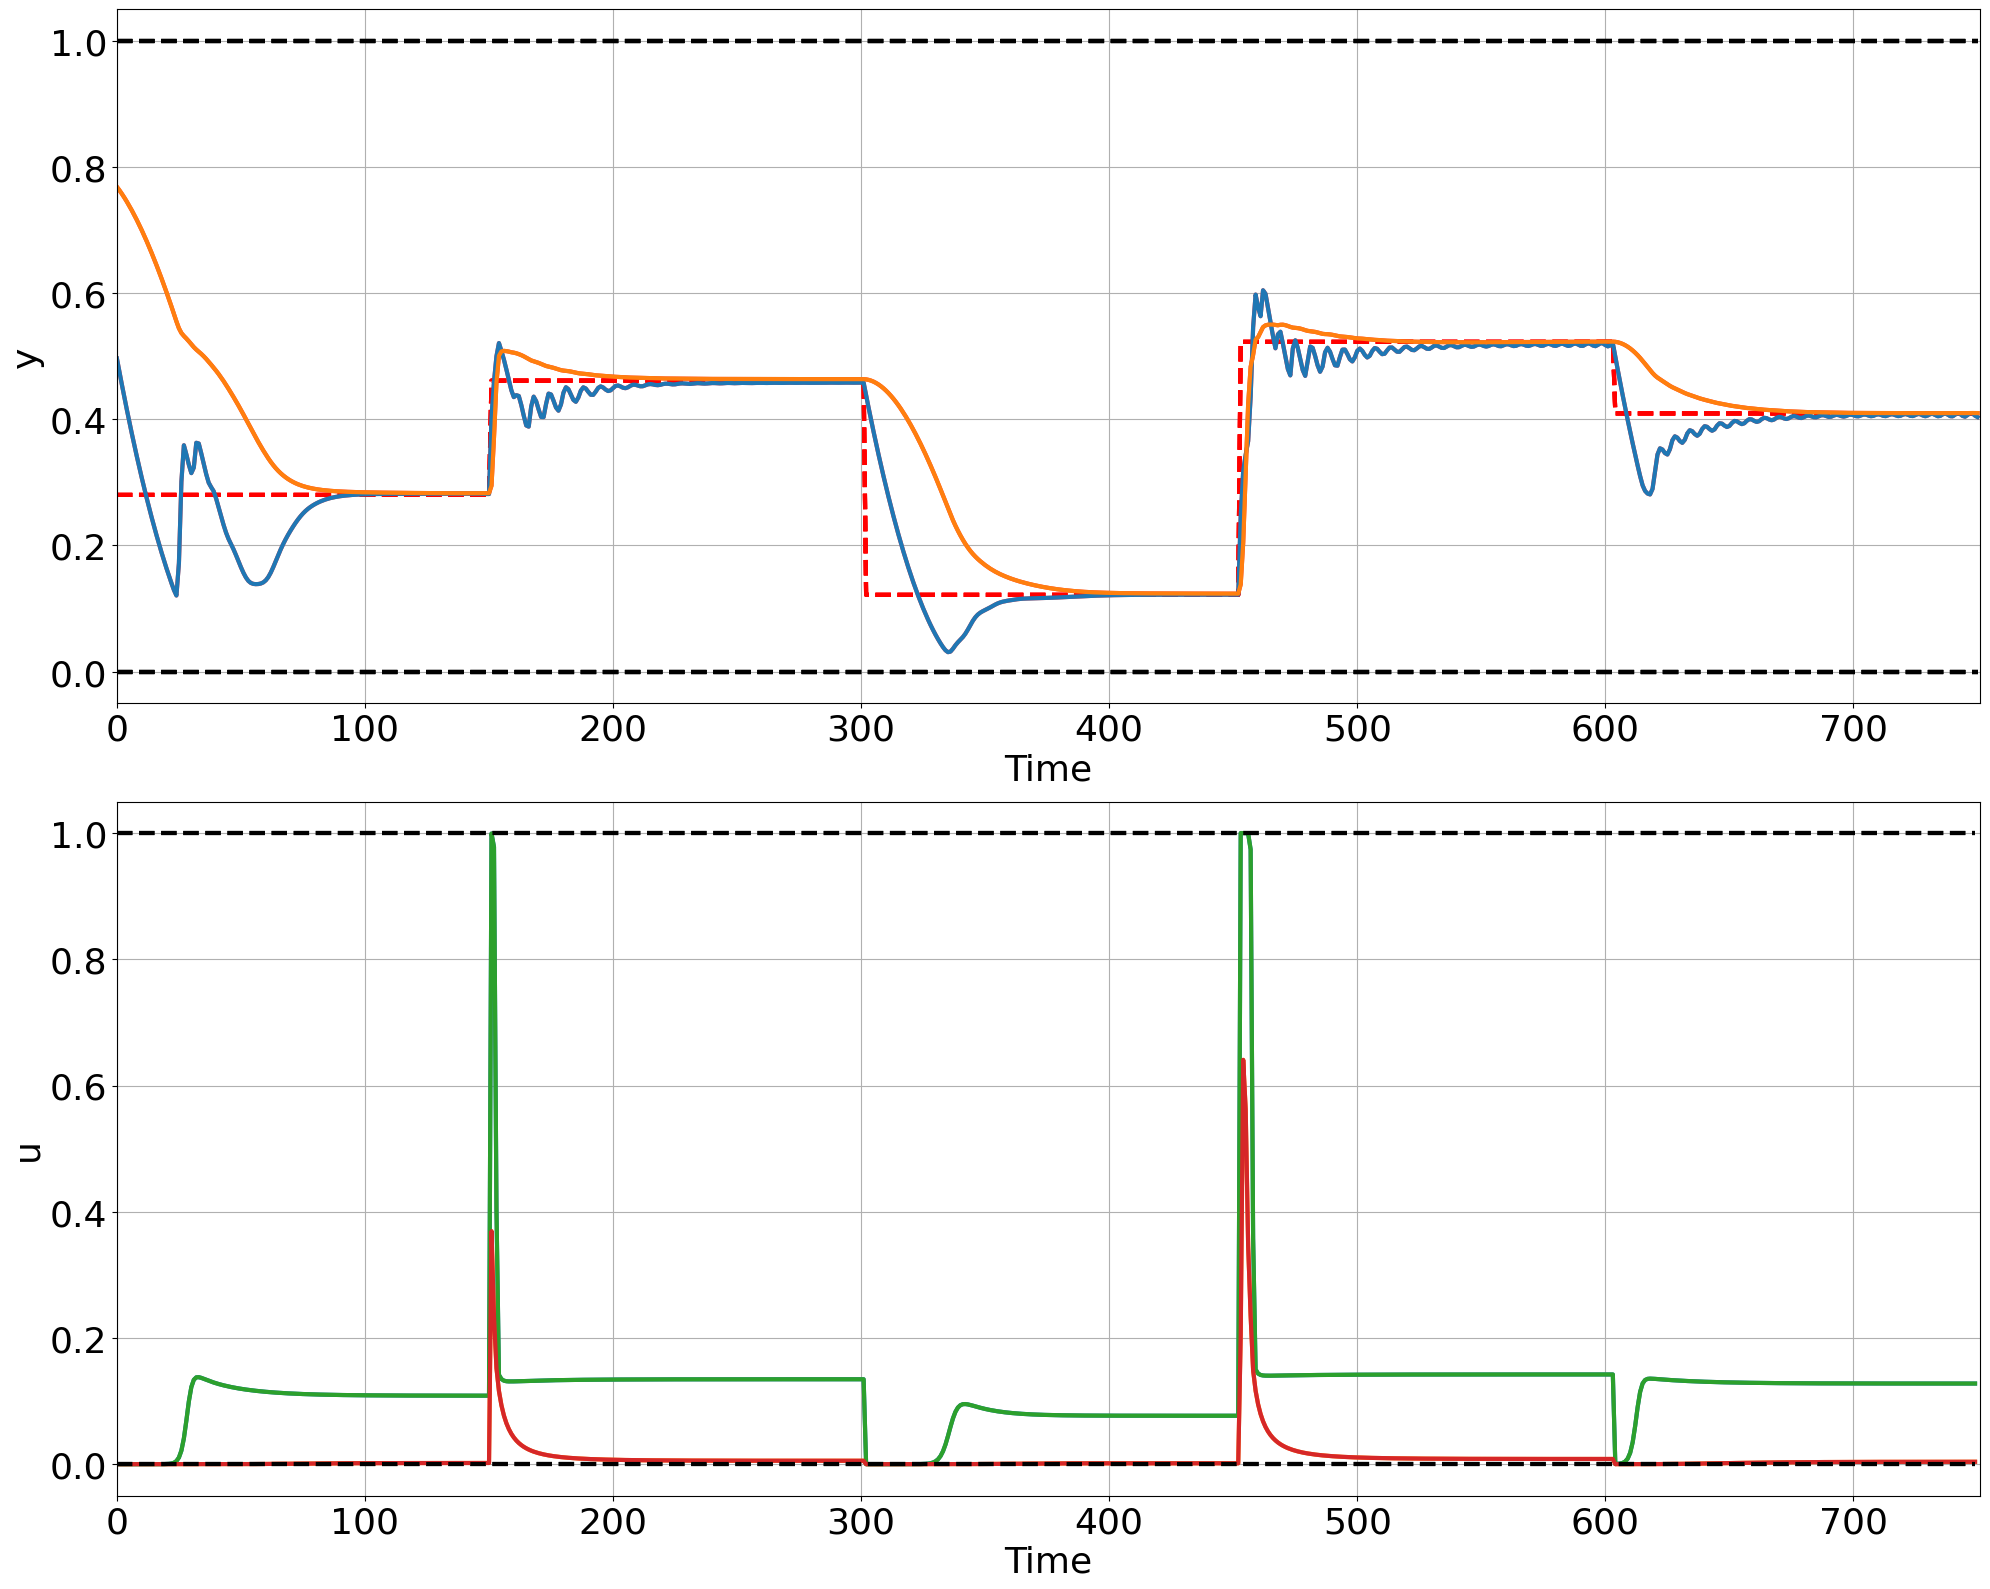

In [50]:
pltCL(Y=x_trajectory.detach().squeeze(0),
      R=data['r'][:,:len(x_trajectory.detach().squeeze(0)),:].squeeze(0),
      U=trajectories['u'].detach()[:,:len(x_trajectory.detach().squeeze(0)),:].squeeze(0),
      Umin=Umin, Umax=Umax, Ymin=Xmin, Ymax=Xmax)

(<Figure size 2000x1600 with 2 Axes>,
 array([[<Axes: xlabel='Time', ylabel='y'>],
        [<Axes: xlabel='Time', ylabel='u'>]], dtype=object))

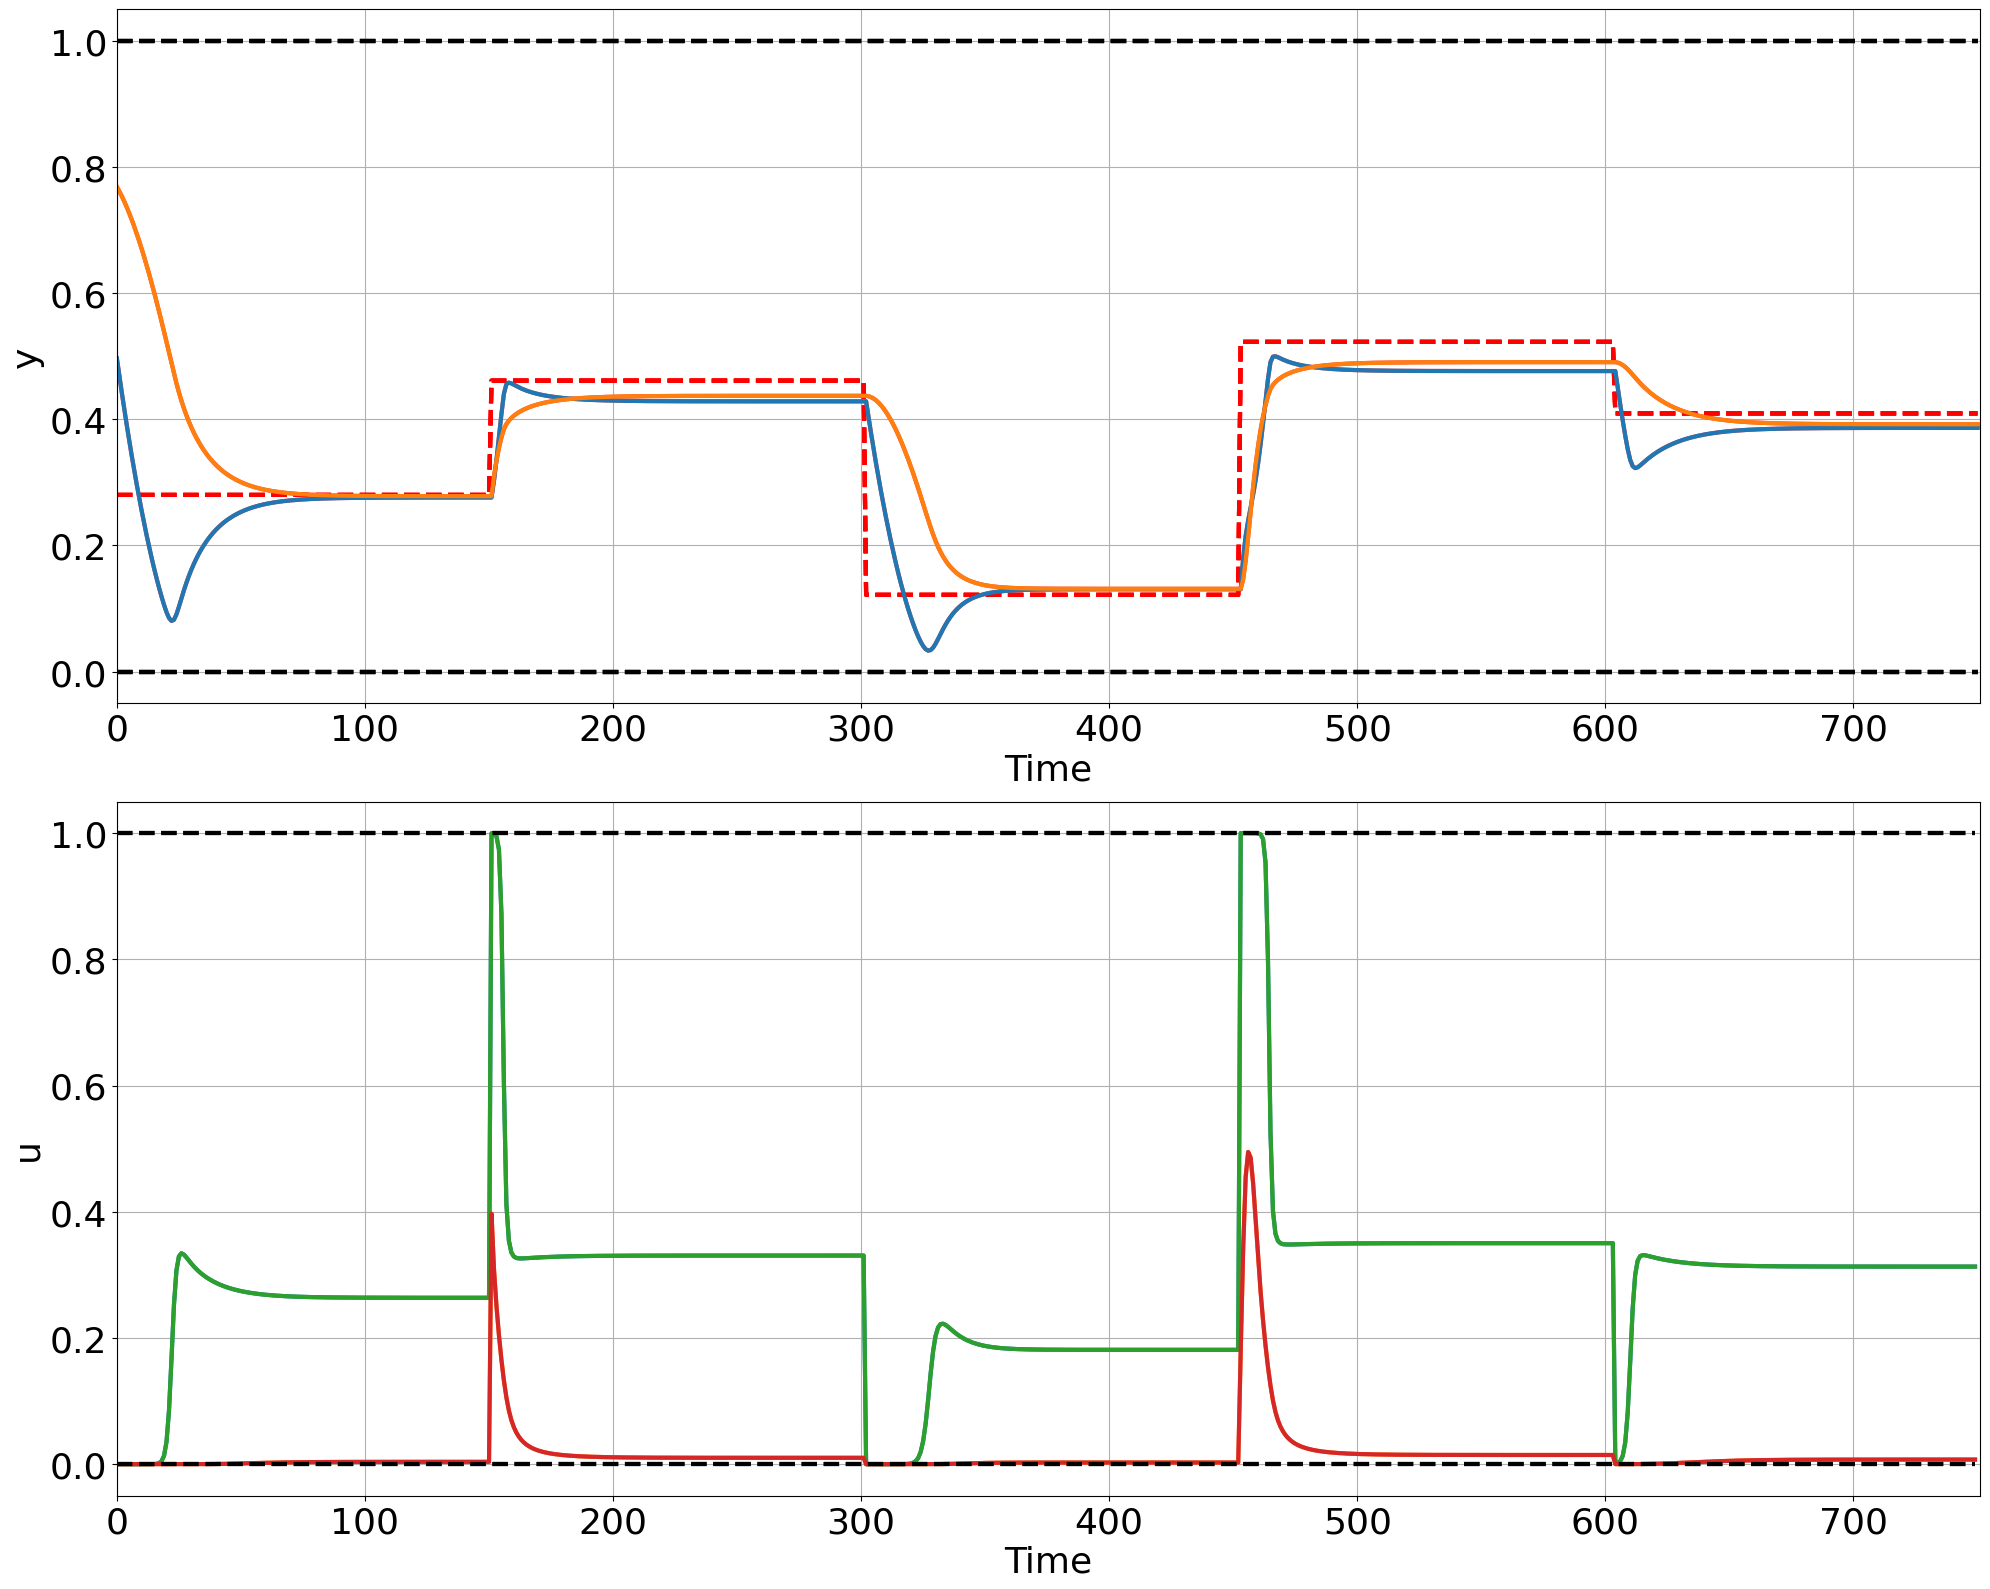

In [51]:
two_tank.c1 = nn.Parameter(torch.tensor(gt_model.c1, requires_grad=False))
two_tank.c2 = nn.Parameter(torch.tensor(gt_model.c2, requires_grad=False))

cl_system.nsteps = nsteps
# perform closed-loop simulation
trajectories = cl_system(data)

# constraints bounds
Umin = umin * np.ones([nsteps, nu])
Umax = umax * np.ones([nsteps, nu])
Xmin = xmin * np.ones([nsteps+1, nx])
Xmax = xmax * np.ones([nsteps+1, nx])
# plot closed loop trajectories
pltCL(Y=trajectories['xn'].detach().reshape(nsteps + 1, nx),
      R=trajectories['r'].detach().reshape(nsteps + 1, nref),
      U=trajectories['u'].detach().reshape(nsteps, nu),
      Umin=Umin, Umax=Umax, Ymin=Xmin, Ymax=Xmax)